You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.



stores.csv

This file contains anonymized information about the 45 stores, indicating the type and size of store.



train.csv

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

* Store - the store number
* Dept - the department number
* Date - the week
* Weekly_Sales -  sales for the given department in the given store
* IsHoliday - whether the week is a special holiday week


test.csv

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.



features.csv

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:



* Store - the store number
* Date - the week
* Temperature - average temperature in the region
* Fuel_Price - cost of fuel in the region
* MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
* CPI - the consumer price index
* Unemployment - the unemployment rate
* IsHoliday - whether the week is a special holiday week


For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

* Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
* Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
* Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
* Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13



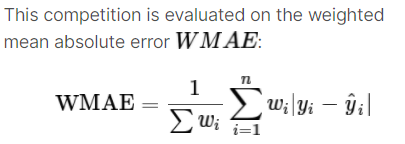

where

* n is the number of rows
* \\( \hat{y}_i \\) is the predicted sales
* \\( y_i \\) is the actual sales
* \\( w_i \\) are weights. w = 5 if the week is a holiday week, 1 otherwise


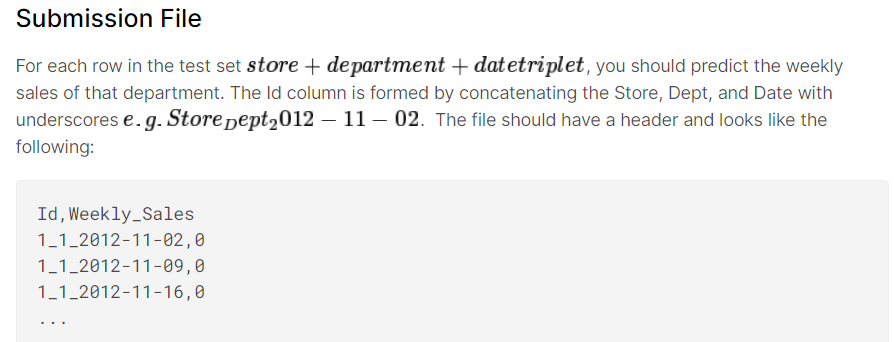

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import warnings
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
'''
Bases: matplotlib.gridspec.GridSpecBase. A grid layout to place subplots within a figure. 
The location of the grid cells is determined in a similar way to SubplotParams using left, right, top, bottom, wspace and hspace.
'''
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore') 
from pandasql import sqldf
'''
pandasql allows you to query pandas DataFrames using SQL syntax. 
It works similarly to sqldf in R. pandasql seeks to provide a more familiar way of manipulating and cleaning data for people new to Python or pandas.

'''

In [ ]:
features = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/features.csv.zip')
train = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/train.csv.zip')
stores = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/test.csv.zip')
sample_submission = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')


In [ ]:
features.head()

In [ ]:
train.tail()

In [ ]:
stores.head()

In [ ]:
test.head()

In [ ]:
sample_submission.head()

###  Exploratory Analysis & Data Cleaning

* In this section, we will explore the datasets provided, join information between some of them and make relevant transformations.

* Let's start by merging data from two of the datasets: features and stores. They have a commom key 'Stores'. The data will be loaded into 'feat_sto'.



In [ ]:
features.shape, train.shape, stores.shape, test.shape

In [ ]:
feature_store = features.merge(stores, how='inner', on = "Store")

In [ ]:
feature_store.head()

In [ ]:
feature_store.dtypes

As we can see, the 'Date' field has string type. We can convert them to datetime and see as well if 'train' and 'test' dataframes has 'Date' type to convert.



In [ ]:
print("train datatype:\n")
print(train.dtypes,"\n")
print("------------------------------------------------------------\n")
print("test datatype:\n")
print(test.dtypes)


In [ ]:
feature_store.Date = pd.to_datetime(feature_store.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [ ]:
feature_store.Date[0]

The 'Date' field doesn't represent the day itself, but each week, ending every friday. So, it's interesting two create a 'Week' field and also we can create one for 'Year'.



In [ ]:
feature_store['Week'] = feature_store.Date.dt.week
feature_store['Year'] = feature_store.Date.dt.year


In [ ]:
train_detail = train.merge(feature_store, how='inner',
                          on = ['Store','Date','IsHoliday']).sort_values(
    by=['Store','Dept','Date']).reset_index(drop=True)

In [ ]:
train_detail.head()

In [ ]:
test_detail = test.merge(feature_store, how='inner',
                         on = ['Store','Date','IsHoliday']).sort_values(
by = ['Store','Dept','Date']).reset_index(drop=True)

In [ ]:
test_detail.head()

In [ ]:
# free space
del features, train, stores, test

In [ ]:
train_detail.isnull().sum()

In [ ]:
test_detail.isnull().sum()

In [ ]:
null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data


This is important, there are columns with more than 60% of null values. If the correlations of these features with the target 'WeeklySales' are ~0, then it is not a good idea to use them. Also, they are anonymized fields, it can be difficult to know what they mean.



### Holidays Analysis

Let's take a look at the Average Weekly Sales per Year and find out if there are another holiday peak sales that were not considered by 'IsHoliday' field.



In [ ]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()


plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)


plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=18)
plt.title('Average Weekly Sales - Per Year', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()


As we can see, there is one important Holiday not included in 'IsHoliday'. It's the Easter Day. It is always in a Sunday, but can fall on different weeks.

* In 2010 is in Week 13
* In 2011, Week 16
* Week 14 in 2012
* and, finally, Week 13 in 2013 for Test set

So, we can change to 'True' these Weeks in each Year.




In [ ]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True


The same chart, but showing also the median of the Sales and not divided by Year:



In [ ]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()

plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)

plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=18)
plt.title('Weekly Sales - Mean and Median', fontsize=20)
plt.ylabel('Sales', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.show()


Just as an observation, the mean and the median are very different, suggesting that some stores/departments might sell much more than others.



Average Sales per Store and Department


In [ ]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()

plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values)

plt.grid()
plt.title("Average Sales - per Store", fontsize = 20)
plt.ylabel('Sales', fontsize=18)
plt.xlabel("Store", fontsize=18)
plt.show()


there are Sales difference between the Store

In [ ]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()

plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values)
plt.grid()
plt.title("Average Sales - per Dept",fontsize=20)
plt.ylabel("Sales", fontsize=18)
plt.xlabel("Dept", fontsize=18)
plt.show()


And there are Sales difference between the Departments too. Also some Depts are not in the list, like number '15', for example.



### Variables Correlation

Let's see the correlation between variables, using Pearson Correlation.



Correlation Metrics:

* 0: no correlation at all
* 0-0.3: weak correlation
* 0.3-0.7: moderate correlaton
* 0.7-1: strong correlation

Positive Correlation indicates that when one variable increase, the other also does. Negative is the opposite.



In [ ]:
sns.set(style='white')
corr = train_detail.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
'''
numpy. triu (m, k=0)[source] Upper triangle of an array. 
Return a copy of an array with the elements below the k-th diagonal zeroed.
'''
f, ax = plt.subplots(figsize=(20,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title("Correlation Matrix", fontsize=20)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink":1}, annot=True)

plt.show()

'MarkDown' 1 to 5 are not strong correlated to 'Weekly_Sales' and they have a lot of null values, then we can drop them.

Also, 'Fuel_Price' is strong correlated to 'Year'. One of them must be dropped else they would carry similar information to the model. 'Year' will not be dropped, because it differentiate same Weeks for 'Store'+'Dept'.

Other variables that have weak correlation with 'Weekly_Sales' can be analyzed to see if they are useful.

In [ ]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])


### Analyzing Variables


First, two plot functions that will help us.

The discrete plot is for finite numbers. We will use boxplot, to see the medians and interquartile ranges, and the striplot, which is a better way of seeing the distribution, even more when lots of outliers are present.

The continuous plot, as the name says, is for continuous variables. We will see the distribution of probabilities and use BoxCox to understand if there is increase of correlation and decrease of skewness for each variable. In some cases the process of transforming a variable can help, depending on the model.



In [ ]:
def make_discrete_plot(feature):
    
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    
    sns.boxplot(y = train_detail.Weekly_Sales, x=train_detail[feature],
               ax=fig.add_subplot(gs[0,0]))
    
    plt.ylabel("Sales", fontsize=18)
    plt.xlabel(feature, fontsize=18)
    sns.stripplot(y_train_detail.Weekly_Sales, x=train_detail[feature])

In [ ]:
def make_discrete_plot(feature):
    
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    
    sns.boxplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    
    plt.ylabel('Sales', fontsize=18)
    plt.xlabel(feature, fontsize=18)
    
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    
    plt.ylabel('Sales', fontsize=18)
    plt.xlabel(feature, fontsize=18)
    fig.show()


In [ ]:

'''
Normality assumptions are critical for many univariate intervals and hypothesis tests. 
It is important to test the normality assumption. If the data are in fact clearly not normal, 
the Box-Cox normality plot can often be used to find a transformation that will approximately normalize the data.
'''
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()


### Weekly_Sales x is Holiday

In [ ]:
make_discrete_plot("IsHoliday")

This field is going to be important to differentiate Week Holidays. As we can see, Week Holidays have more high sales events than non-Holiday Weeks.



weekly_Sales X Type

In [ ]:
make_discrete_plot('Type')


We don't know what 'Type' is, but we can assume that A > B > C in terms of Sales Median. So, let's treat it as an ordinal variable and replace its values.

Ordinal variables are explained in the figure below.



In [ ]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))


### Weekly_sales x Temperature

In [ ]:
make_continuous_plot("Temperature")

Although skewness changes, correlation doesn't seem to change at all. We can decide to drop it.



### Weekly Sales x CPI


In [ ]:
make_continuous_plot("CPI")

Although skewness changes, correlation doesn't seem to change at all. We can decide to drop it.



In [ ]:
train_detail = train_detail.drop(columns=["CPI"])
test_detail = test_detail.drop(columns=['CPI'])

### Weekly Sales x Unemployment

In [ ]:
make_continuous_plot('Unemployment')


Although skewness changes, correlation doesn't seem to change at all. We can decide to drop it.



In [ ]:
make_continuous_plot('Size')


And, finally, we will continue with this variable, since it has moderate correlation with 'WeeklySales'.



So, turning the formula into a function, since we can't use GridSearchCV or RandomSearchCV:



### Machine Learning


In [ ]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)


In [ ]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']


In [ ]:
X_train.head()

In [ ]:
Y_train.head()

In [ ]:
def random_forest(n_estimators, max_depth):
    
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)



def random_forest_II(n_estimators, max_depth, max_features):
    
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)


def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)



In [ ]:
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)


In [ ]:
max_features = [2, 3, 4, 5, 6, 7]

random_forest_II(n_estimators=58, max_depth=27, max_features=max_features)


In [ ]:
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

random_forest_III(n_estimators=58, max_depth=27, max_features=6, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)


The final model:



In [ ]:
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, Y_train)


### Predictions


In [ ]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)


In [ ]:
predict

In [ ]:
sample_submission['Weekly_Sales'] = predict
sample_submission.to_csv('submission.csv',index=False)


In [ ]:
sample_submission.head()